In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# Codebook generation for laser pointer visual stimulus

## Condition 1

In [3]:
n_objs = 8

sfreq = 1000
soa = 250
on_duration = 100
off_duration = 150
switch_duration = 500

n_blinks = 12

n_blinked = 0

n_reps = 1

In [4]:
codebook = np.zeros((n_objs, n_blinks * n_objs))

n_blinked = 0
current_obj = 0
for i in range(codebook.shape[0]):
    for j in range(codebook.shape[1]):
        if codebook[:, j].sum() == 0:
            codebook[i, j] = 1
            n_blinked += 1
        if n_blinked == n_blinks:
            n_blinked = 0
            break
        
                
    

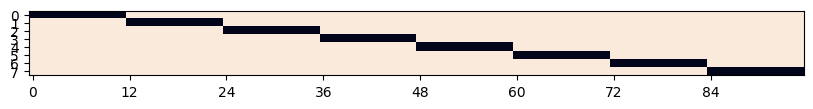

In [5]:
plt.figure(figsize=(10, 10))
plt.imshow(codebook, cmap=sns.cm.rocket_r)
plt.xticks(np.arange(0, codebook.shape[1], n_blinks), np.arange(0, codebook.shape[1], n_blinks))
plt.yticks(np.arange(0, codebook.shape[0]), np.arange(0, codebook.shape[0]))
# plt.grid()
plt.show()

[array([0, 1]), array([0, 0, 1]), array([0, 0, 0, 1]), array([0, 0, 0, 0, 1]), array([0, 0, 0, 0, 0, 1])]
(8, 96)
(8, 101)


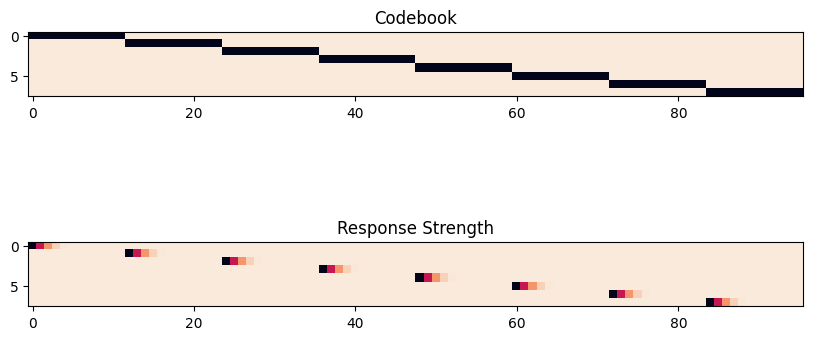

In [6]:
# window = np.linspace(1, 0, n_blinks) ** 4
# window = np.array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ])
window_high = np.array([0, 0, 0, 0, 0, 1])
windows = [window_high[i:] for i in range(len(window_high) - 1)][::-1]
print(windows)
print(codebook.shape)
response_strength = np.zeros_like(codebook)
padding = np.zeros((n_objs, len(window_high) - 1))
codebook_padded = np.hstack([padding, codebook])
print(codebook_padded.shape)
for k, window in enumerate(windows):
    for i in range(codebook.shape[0]):
        for j in range(codebook.shape[1] - len(window) - 1):
            if (codebook_padded[i, j:j+len(window)] == window).sum() == len(window):
                    response_strength[i, j] = k + 1


response_strength = response_strength ** 3
response_strength = response_strength / response_strength.max()

fig, axs = plt.subplots(2, 1, figsize=(10, 5))
axs[0].imshow(codebook, cmap=sns.cm.rocket_r)
axs[0].set_title('Codebook')
axs[1].imshow(response_strength, cmap=sns.cm.rocket_r)
axs[1].set_title('Response Strength')
plt.show()

## Codebook 2

In [1]:
# codebook = np.random.choice([0, 1], size=[codebook.shape[0], codebook.shape[1]], p=[0.8, 0.2])

# # Minimum target to target distance.
# # window = np.linspace(1, 0, n_blinks) ** 4
# # window = np.array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ])
# window_high = np.array([0, 0, 0, 0, 0, 1])
# windows = [window_high[i:] for i in range(len(window_high) - 1)][::-1]
# print(windows)
# print(codebook.shape)
# response_strength = np.zeros_like(codebook)
# padding = np.zeros((n_objs, len(window_high) - 1))
# codebook_padded = np.hstack([padding, codebook])
# print(codebook_padded.shape)
# for k, window in enumerate(windows):
#     for i in range(codebook.shape[0]):
#         for j in range(codebook.shape[1] - len(window) - 1):
#             if (codebook_padded[i, j:j+len(window)] == window).sum() == len(window):
#                     response_strength[i, j] = k + 1

# # response_strength = response_strength ** 3
# response_strength = response_strength / response_strength.max()

# fig, axs = plt.subplots(2, 1, figsize=(10, 5))
# axs[0].imshow(codebook, cmap=sns.cm.rocket_r)
# axs[0].set_title('Codebook')
# axs[1].imshow(response_strength, cmap=sns.cm.rocket_r)
# axs[1].set_title('Response Strength')
# plt.show()

In [2]:
# TNT ration average overtime.

# NOTE: ITR as an objective metric?

# We don't assume targets.
# Highlight probability should be set by user. (Common values are 0.1, 0.2)
# No neighbor in time.
# No neighbor in space(?) not sure.
# 
# distance between object
# Each object should be converged.

In [4]:
# # Function that computes target, non-target ratio of each object from codebook
# def compute_target_ratio(codebook: np.ndarray) -> float:
#     target_ratio = np.zeros(codebook.shape[0])
#     for i in range(codebook.shape[0]):
#         target_ratio[i] = codebook[i].sum() / codebook.shape[1]
#     return target_ratio

# target_ratio = compute_target_ratio(codebook)

In [5]:
n_objs = 8

sfreq = 1000
soa = 250
on_duration = 100
off_duration = 150
switch_duration = 500

n_blinks = 12

n_blinked = 0

n_reps = 1

In [6]:
def compute_response(codebook: np.ndarray, type: str='exp', window_size: int=12) -> float:
    window = np.linspace(0, 1, window_size)
    
    
    

(4, 2250)

In [ ]:
a = np.random.choice([0, 1], size=[4, 32], p=[0.5, 0.5])

for i in range(a.shape[0]): 
    for j in range(a.shape[1]):
        print(f'{int(a[i, j])} ', end='')
    print()

In [ ]:
int(a[i, j])